In [1]:
#------------FFN----------------

# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:

import gdown  # Allows us to use a Google Drive hosted data file
file_id = '1-CvtEzDoTFsJ5cAnafBS608prTUAl1Vf'
url = f'https://drive.google.com/uc?export=download&id={file_id}'

# Destination file path
output = 'age_gender.csv'

# Download the file
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1-CvtEzDoTFsJ5cAnafBS608prTUAl1Vf
From (redirected): https://drive.google.com/uc?export=download&id=1-CvtEzDoTFsJ5cAnafBS608prTUAl1Vf&confirm=t&uuid=9dde35c7-8570-4bdd-a116-13d189710335
To: /content/age_gender.csv
100%|██████████| 200M/200M [00:03<00:00, 59.1MB/s]


'age_gender.csv'

In [3]:
# Load the data
df = pd.read_csv(output)

# Display basic information from dataset
print(df.info())
print(df.head())
print(df.describe())
print(df.shape)

file_path = '/content/age_gender.csv'

# Load the dataset
age_gender = pd.read_csv(file_path)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB
None
   age  ethnicity  gender                        img_name  \
0    1          2       0  20161219203650636.jpg.chip.jpg   
1    1          2       0  20161219222752047.jpg.chip.jpg   
2    1          2       0  20161219222832191.jpg.chip.jpg   
3    1          2       0  20161220144911423.jpg.chip.jpg   
4    1          2       0  20161220144914327.jpg.chip.jpg   

                                              pixels  
0  129 128 128 126 127 130 133 135 139 142 145 14...  
1  164 74 111 168 169 171 175 182 184 188 193 199...  
2  67 70 71 70 69 67 70 79 90 

In [4]:
# Display the first few rows of the dataset
print(age_gender.head())
print(age_gender.shape)
print(age_gender.dtypes)
print(age_gender.isnull().sum())
print(age_gender.describe())

   age  ethnicity  gender                        img_name  \
0    1          2       0  20161219203650636.jpg.chip.jpg   
1    1          2       0  20161219222752047.jpg.chip.jpg   
2    1          2       0  20161219222832191.jpg.chip.jpg   
3    1          2       0  20161220144911423.jpg.chip.jpg   
4    1          2       0  20161220144914327.jpg.chip.jpg   

                                              pixels  
0  129 128 128 126 127 130 133 135 139 142 145 14...  
1  164 74 111 168 169 171 175 182 184 188 193 199...  
2  67 70 71 70 69 67 70 79 90 103 116 132 145 155...  
3  193 197 198 200 199 200 202 203 204 205 208 21...  
4  202 205 209 210 209 209 210 211 212 214 218 21...  
(23705, 5)
age           int64
ethnicity     int64
gender        int64
img_name     object
pixels       object
dtype: object
age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64
                age     ethnicity        gender
count  23705.000000  23705.000000  23705.0

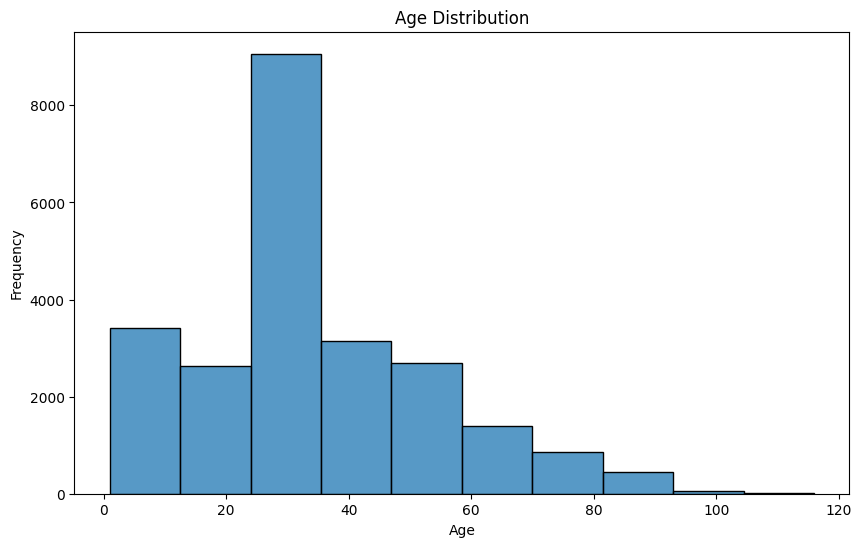

In [5]:
# Data visualization
plt.figure(figsize=(10, 6))
sns.histplot(age_gender['age'], bins=10, kde=False)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [6]:
# Drop unnecessary column
age_gender.drop('img_name', axis=1, inplace=True)

In [7]:
# Check the lengths of the pixel sequences
pixel_lengths = age_gender['pixels'].apply(lambda x: len(x.split()))
print(pixel_lengths.value_counts())  # See if there are different lengths

# Expected length for 48x48 images
expected_length = 48 * 48

# Filter out rows with incorrect pixel lengths
age_gender = age_gender[pixel_lengths == expected_length]

# Verify that all remaining sequences have the correct length
pixel_lengths = age_gender['pixels'].apply(lambda x: len(x.split()))
print(pixel_lengths.value_counts())  # Should show only one length

pixels
2304    23705
Name: count, dtype: int64
pixels
2304    23705
Name: count, dtype: int64


In [8]:
# Convert the 'pixels' column to arrays
X = np.array(age_gender['pixels'].apply(lambda x: np.array(x.split(), dtype='float32')).tolist())

# Flatten arrays to vectors for FFN
X = X.reshape(-1, 48 * 48)

# Check the shape to ensure it's correct
print(X.shape)

# Extract target variables
y_gender = to_categorical(age_gender['gender'], 2)

(23705, 2304)


In [9]:
# Split data into training and testing sets
X_train, X_test, y_train_gender, y_test_gender = train_test_split(X, y_gender, test_size=0.2, random_state=42)

# Normalize the pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

In [10]:
# Model architecture for FFN with increased complexity
model = Sequential([
    Dense(1024, activation='relu', input_shape=(48 * 48,), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(2, activation='softmax')  # 2 units and softmax activation for binary classification
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

In [12]:
# Train the model with early stopping and learning rate reduction
history = model.fit(
    X_train, y_train_gender,
    epochs=50,  # Train for more epochs
    batch_size=32,
    validation_data=(X_test, y_test_gender),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
167/593 [=======>......................] - ETA: 33s - loss: 2.7755 - accuracy: 0.5159

KeyboardInterrupt: 

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_gender)
print(f'Validation Accuracy: {accuracy*100:.2f}%')

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()